<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
from math import sqrt

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Прочитаем файл в датафрейм, назначив даты индексом

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим первые строки фрейма и общую информацию

In [3]:
def df_analyse(data):
    data.info()
    display(data.head(10))
    display(data.tail(10))
    display(data.describe())
    print(f'размер:    {data.shape}')
    print('пропусков:         ', data.isna().sum().sum())
df_analyse(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


размер:    (26496, 1)
пропусков:          0


Проверим индекс на монотонность

In [4]:
data.index.is_monotonic

True

Ресемплируем данные по часу

In [5]:
data = data.resample('1H').sum()

## Анализ

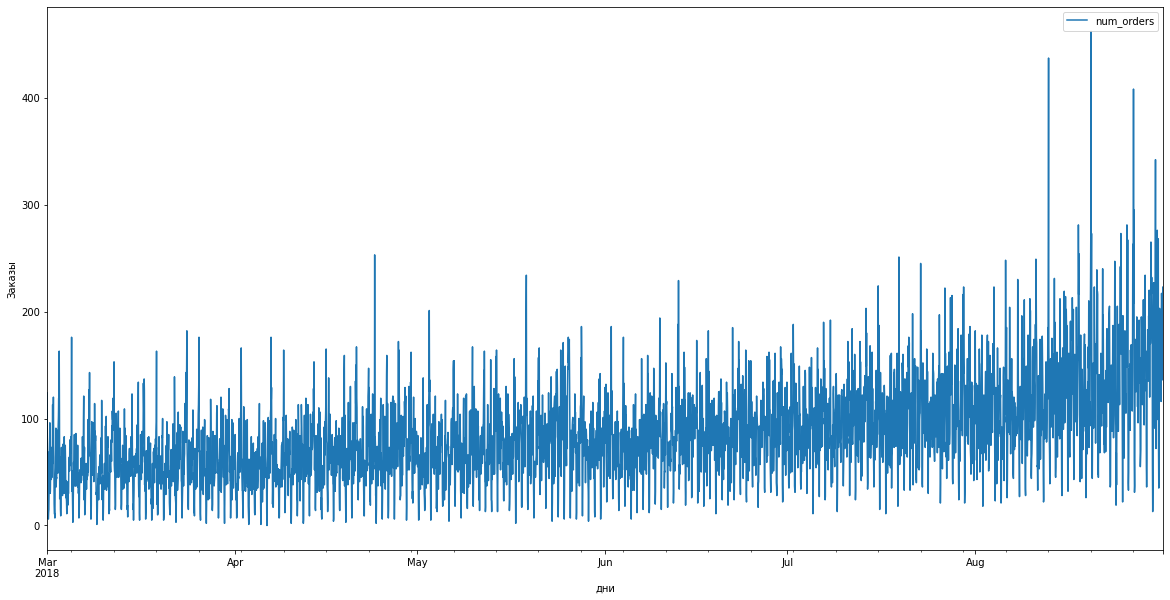

In [6]:
data.plot(xlabel='дни', ylabel='Заказы', figsize=(20,10));

In [7]:
data_new = data.copy()

In [8]:
data_new["rolling_mean"] = data_new["num_orders"].rolling(20).mean()
data_new["rolling_std"] = data_new["num_orders"].rolling(20).std()

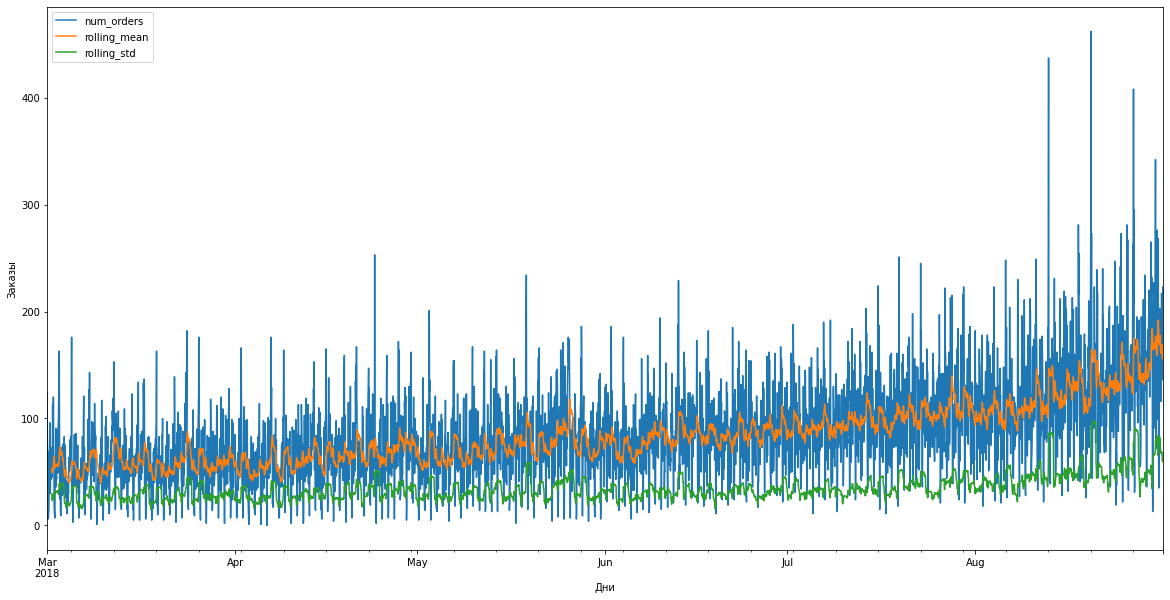

In [9]:
data_new.plot(xlabel='Дни', ylabel='Заказы', figsize=(20,10));

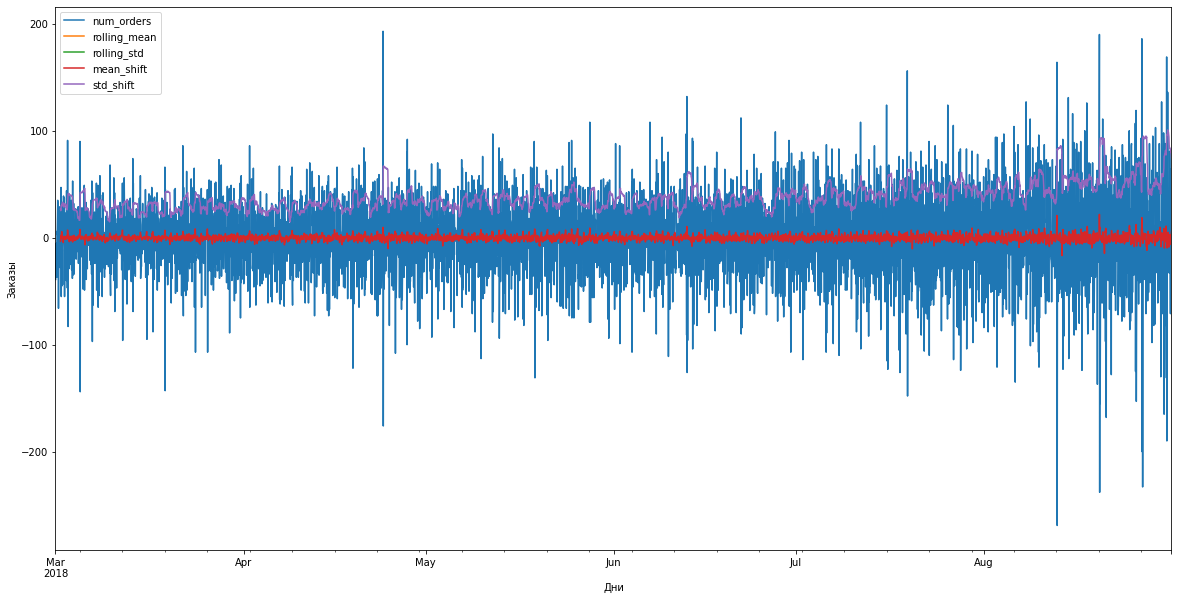

In [10]:
data_shift = data_new - data.shift()
data_shift['mean_shift'] = data_shift['num_orders'].rolling(20).mean()
data_shift['std_shift'] = data_shift['num_orders'].rolling(20).std()
data_shift.plot(xlabel='Дни', ylabel='Заказы',figsize=(20,10));

Дисперсия ряда со временем увеличивается.

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени. Это можно подтвердить критерием Дики-Фуллера.

Нулевая гипотеза гласит: "Временной ряд является нестацинарным". Альтернативная: "Временной ряд стационарен"


In [11]:
p_value = adfuller(data['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


In [12]:
p_value = adfuller(data['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


Проверка по критерию Дики-Фуллера по уровню значимости 1% показала, что данный ряд не стационарен

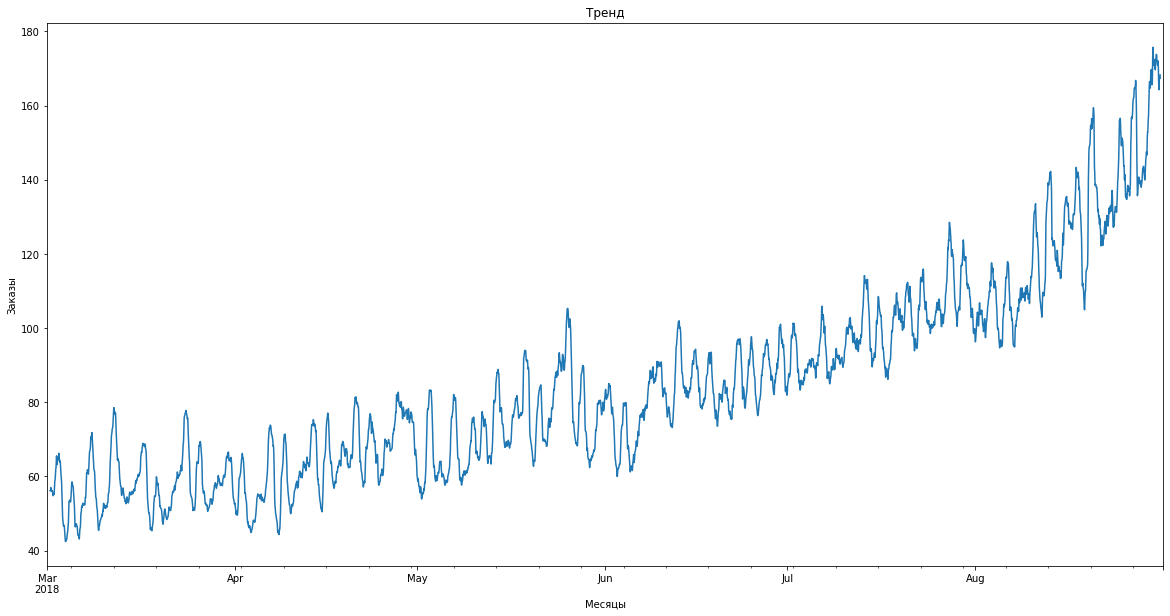

In [13]:
decomposed= seasonal_decompose(data)
decomposed.trend.plot(figsize=(20,10),xlabel='Месяцы', ylabel='Заказы',title='Тренд');

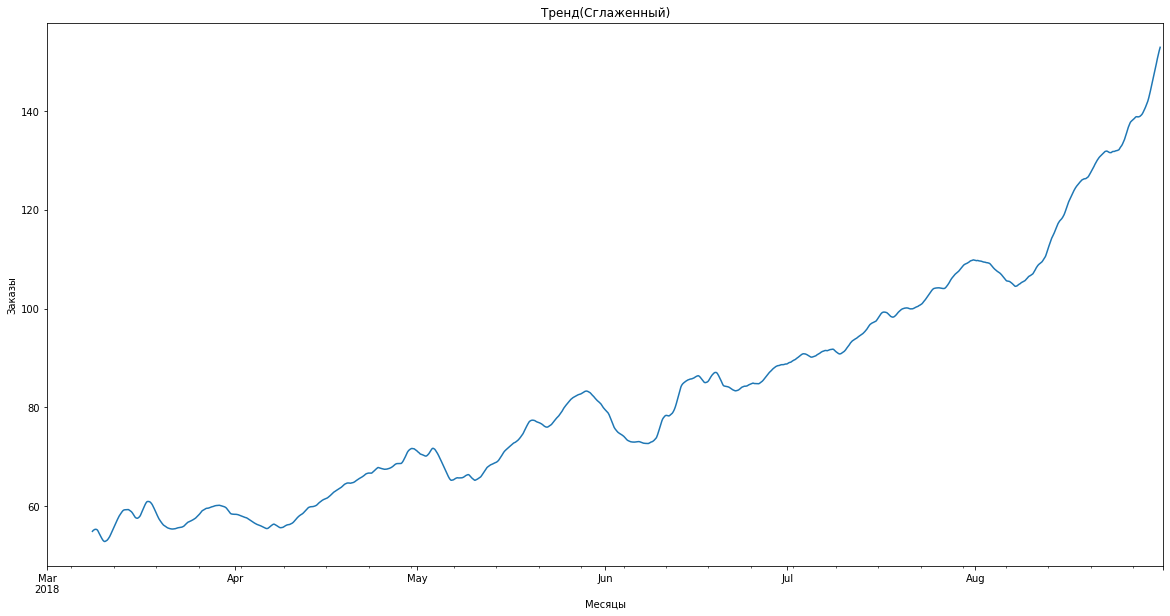

In [14]:
decomposed.trend.rolling(24*7).mean().plot(figsize=(20,10),xlabel='Месяцы', ylabel='Заказы', title='Тренд(Сглаженный)');

По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.

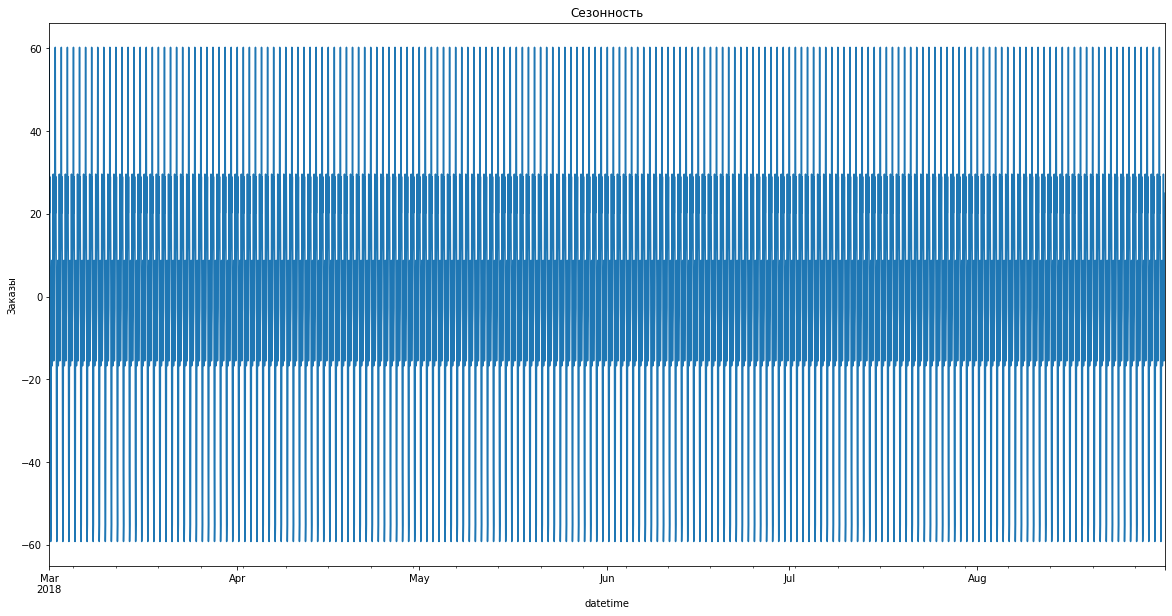

In [15]:
decomposed.seasonal.plot(title='Сезонность',figsize=(20,10))
plt.ylabel('Заказы');

Граффик показвает высокую частотность и суточную сезонность

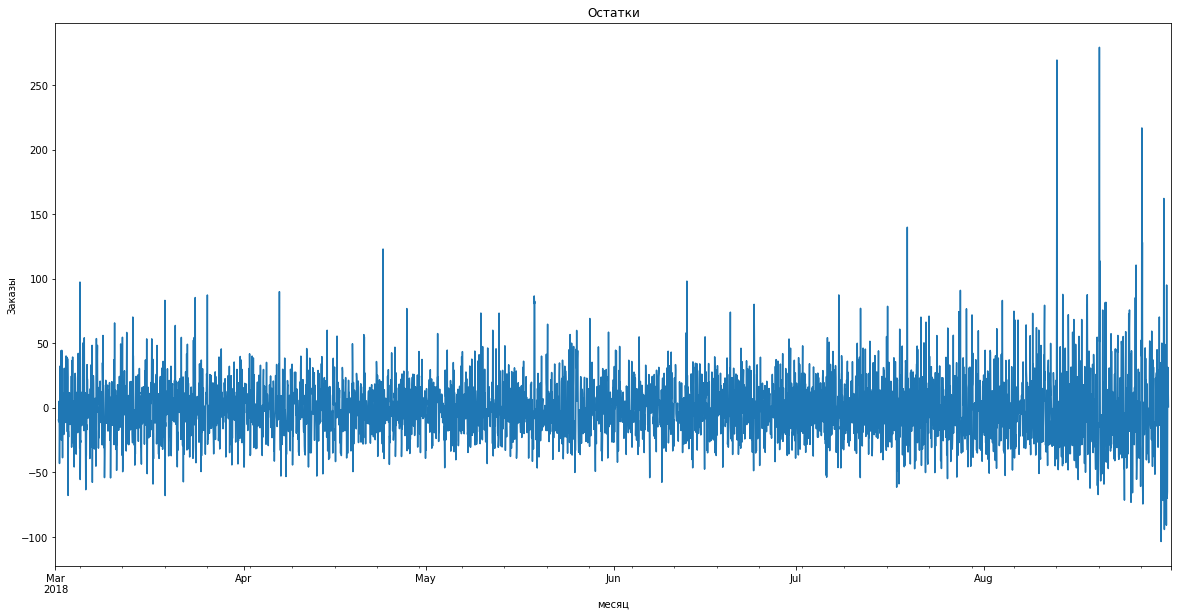

In [16]:
decomposed.resid.plot(figsize=(20,10),xlabel='месяц', ylabel='Заказы',title='Остатки');

Шумность в августе возросла,скорее всего появилось много не систематических составляющих

Проверим на интервалах поменьше

In [17]:
decomposed_week = seasonal_decompose(data['2018-08-20':'2018-08-26'])
decomposed_month = seasonal_decompose(data.resample('1D').sum()['2018-08-01':'2018-08-31'])

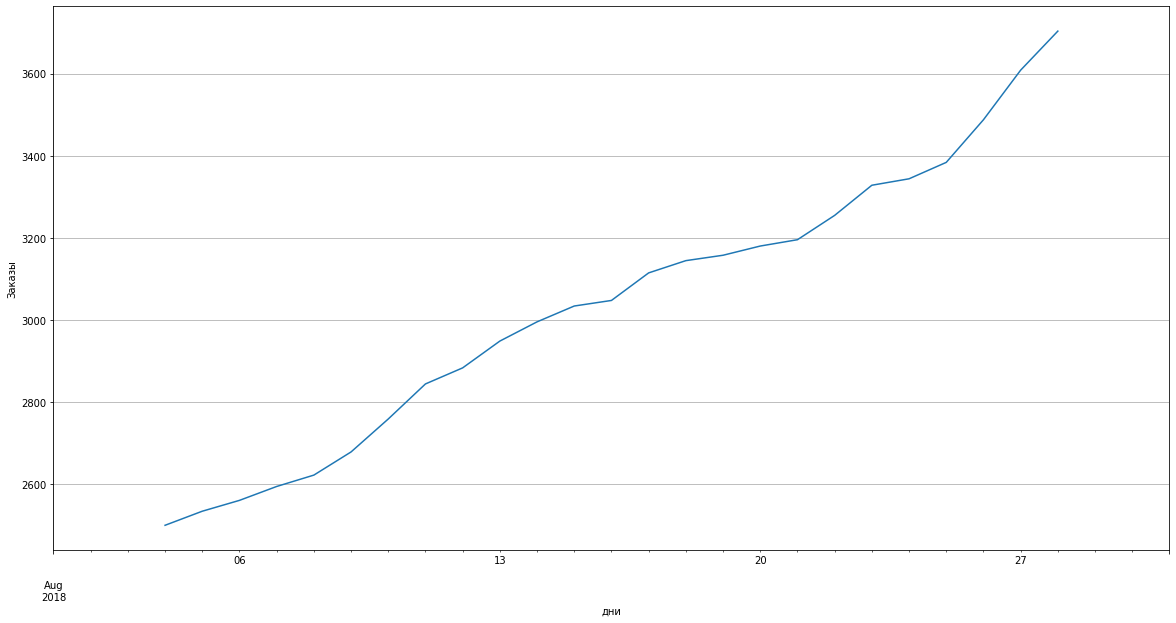

In [18]:
decomposed_month.trend.plot(figsize=(20,10),xlabel='дни', ylabel='Заказы',grid=True);

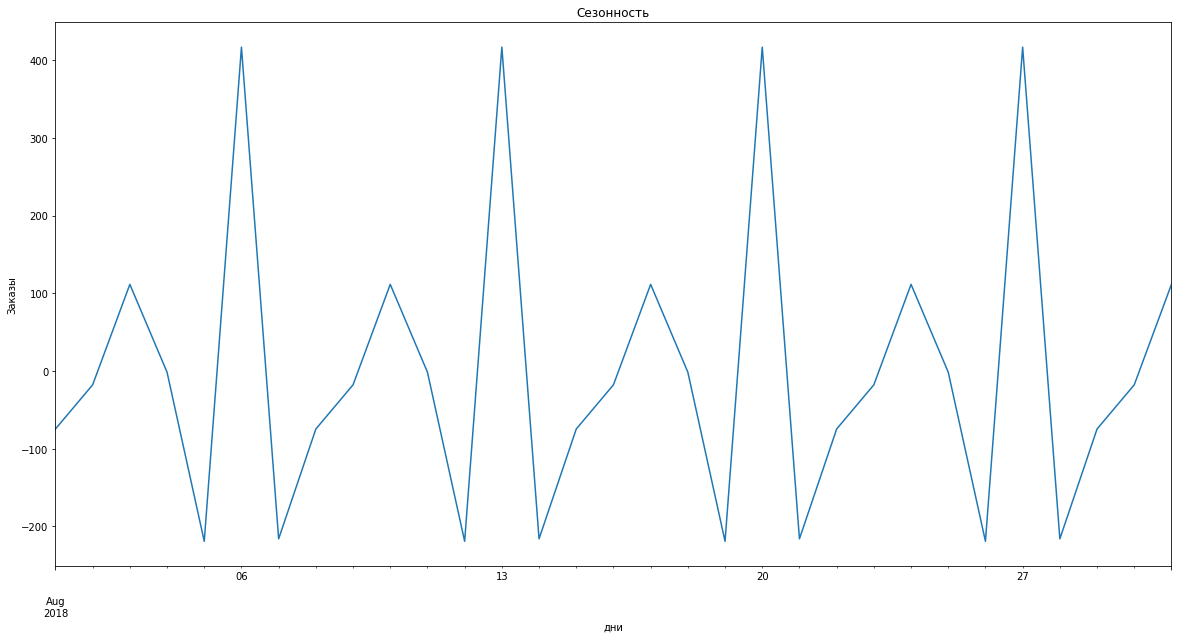

In [19]:
decomposed_month.seasonal.plot(title='Сезонность',figsize=(20,10),xlabel='дни', ylabel='Заказы');

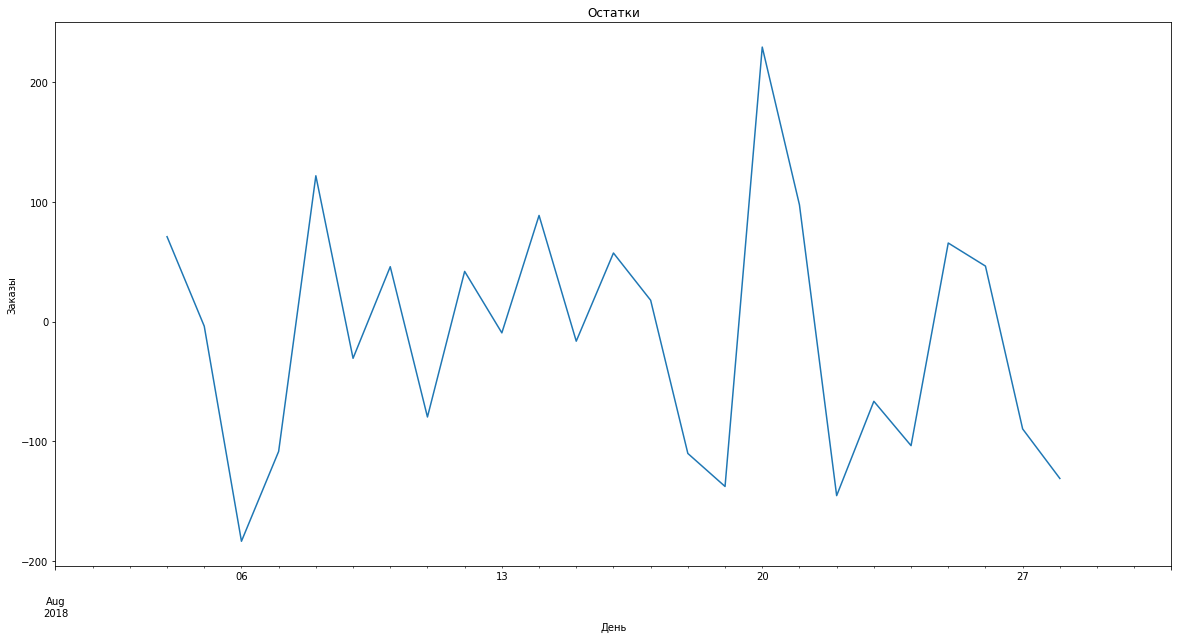

In [20]:
decomposed_month.resid.plot(figsize=(20,10),xlabel='День', ylabel='Заказы',title='Остатки');

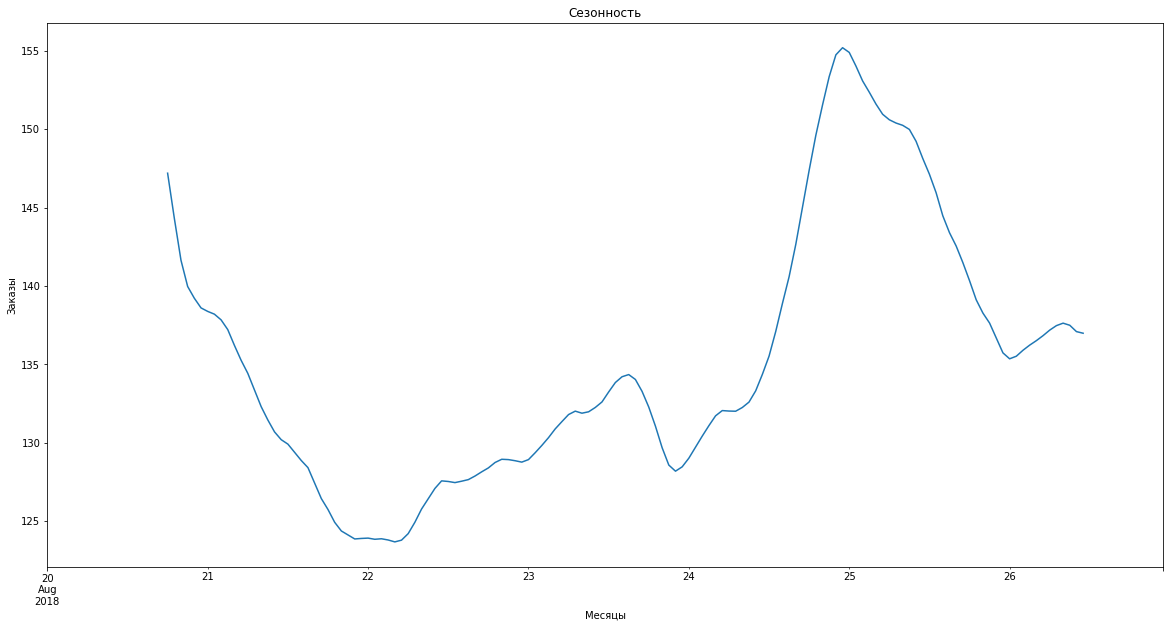

In [21]:
decomposed_week.trend.rolling(7).mean().plot(figsize=(20,10),xlabel='Месяцы', ylabel='Заказы', title='Сезонность');

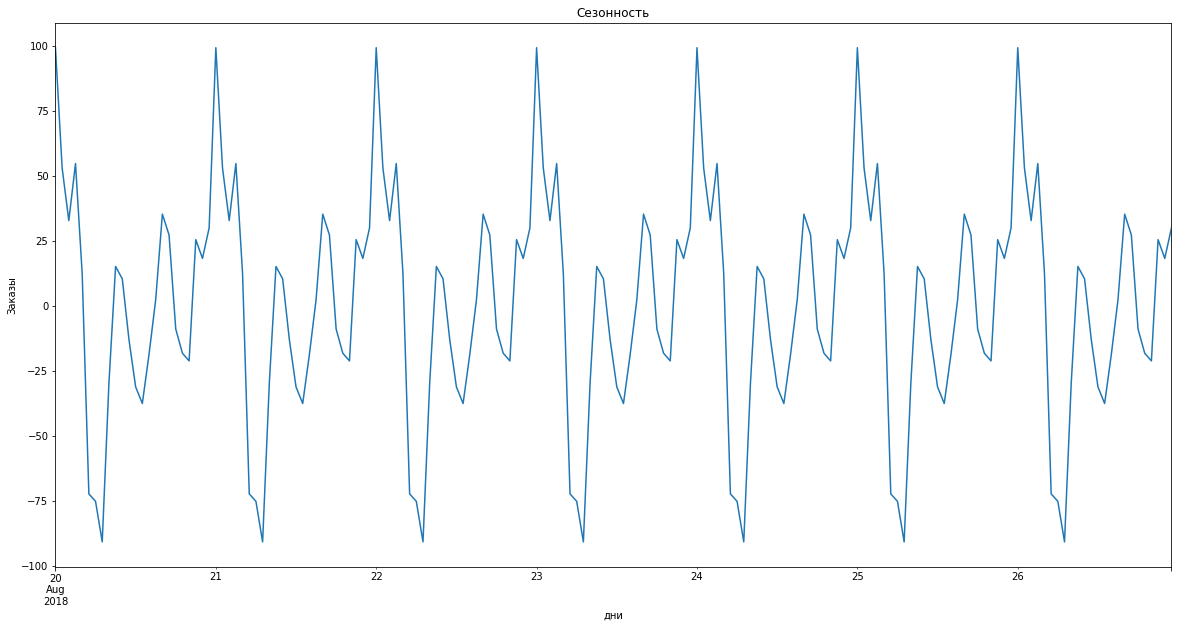

In [22]:
decomposed_week.seasonal.plot(title='Сезонность',figsize=(20,10),xlabel='дни', ylabel='Заказы');

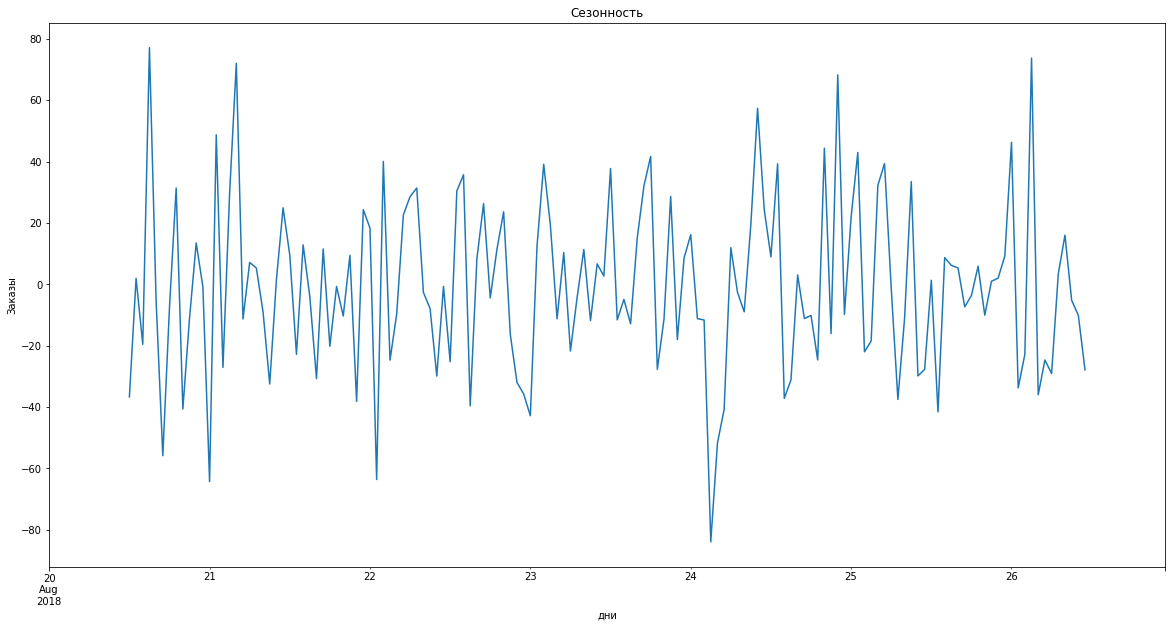

In [23]:
decomposed_week.resid.plot(figsize=(20,10),xlabel='дни', ylabel='Заказы', title='Сезонность');

Видна недельная и суточная сезонность. Суточная сезонность проявляет себя в постепенном скачкообразным повышением кол-ва заказов с пиком ночю потом идет резкий спад к утру. недельная сезонность проявляет себя возрастанием кол-ва заказов в конце недели и спадах в начале недели. 

### Вывод

    Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями.
    Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру. 
    Приросты заказов выбранном интервал(август) можно обусловить окончанием каникул и отпусков. 

## Обучение

### Подготовка признаков

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [25]:
data_copy = data.copy()
make_features(data,24,11)

In [26]:
data.shape

(4416, 28)

In [27]:
data_copy.shape

(4416, 1)

In [28]:
data.dropna(inplace=True)

Разделим данные на обучающую и тестовую выборки

In [29]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)


In [31]:
features_train.shape

(3952, 27)

In [32]:
features_test.shape

(440, 27)

Обучим различные модели и добавим модели и рассчитанный RMSE в массив

### Линейная регрессия

In [33]:
train_models = []

In [34]:
tscv = TimeSeriesSplit(n_splits=3)

In [35]:
lr= LinearRegression()

In [36]:
rmse=(cross_val_score(lr, features_train, target_train, cv=tscv,  scoring='neg_mean_squared_error').mean() * -1) ** 0.5
rmse

27.912850641192907

In [37]:
train_models.append([lr, rmse])

### Дерево решений

In [38]:
dtr = DecisionTreeRegressor(random_state=12345)

In [39]:
rmse=(cross_val_score(dtr,features_train, target_train,cv=tscv, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
rmse

36.042723748666276

In [40]:
train_models.append([dtr, rmse])

### RandomForestRegressor

In [41]:
rfr = RandomForestRegressor(random_state=12345)

In [42]:
rfr_parametrs = {'n_estimators': range(70, 100, 10),
                     'max_depth': range(5, 20, 5),
                     'min_samples_leaf': range(1,3)}

In [43]:
rfr_grid = GridSearchCV(rfr, rfr_parametrs,cv=tscv, scoring='neg_mean_squared_error')
rfr_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 20, 5),
                         'min_samples_leaf': range(1, 3),
                         'n_estimators': range(70, 100, 10)},
             scoring='neg_mean_squared_error')

In [44]:
rfr_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 80}

In [45]:
rmse=sqrt(rfr_grid.best_score_*-1)
rmse

27.593747335410672

rfr_parametrs = {'n_estimators':range(50,100,10), 'max_depth':range(5,20,5)}

In [46]:
train_models.append([rfr_grid, rmse])

### CatBoost

In [47]:
cbr = CatBoostRegressor(loss_function='RMSE',random_state=12345,depth = 10, learning_rate = 0.1)

In [48]:
rmse=(cross_val_score(cbr, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
rmse

0:	learn: 28.1846728	total: 83.1ms	remaining: 1m 22s
1:	learn: 27.0220071	total: 118ms	remaining: 59.1s
2:	learn: 26.0096311	total: 178ms	remaining: 59.1s
3:	learn: 25.1602746	total: 213ms	remaining: 52.9s
4:	learn: 24.3226070	total: 258ms	remaining: 51.3s
5:	learn: 23.4431644	total: 294ms	remaining: 48.7s
6:	learn: 22.6428469	total: 337ms	remaining: 47.8s
7:	learn: 22.0070418	total: 373ms	remaining: 46.2s
8:	learn: 21.3463080	total: 409ms	remaining: 45s
9:	learn: 20.7852425	total: 454ms	remaining: 44.9s
10:	learn: 20.2228397	total: 489ms	remaining: 44s
11:	learn: 19.7873669	total: 539ms	remaining: 44.4s
12:	learn: 19.2480586	total: 575ms	remaining: 43.7s
13:	learn: 18.8129739	total: 610ms	remaining: 42.9s
14:	learn: 18.3688791	total: 656ms	remaining: 43.1s
15:	learn: 17.9301017	total: 690ms	remaining: 42.5s
16:	learn: 17.5451485	total: 735ms	remaining: 42.5s
17:	learn: 17.1657429	total: 771ms	remaining: 42.1s
18:	learn: 16.8228394	total: 807ms	remaining: 41.7s
19:	learn: 16.4838818	to

28.064558235948766

In [49]:
train_models.append([cbr, rmse])

### LightGBM

In [50]:
lgbm=lgb.LGBMRegressor(random_state=12345,num_leaves = 5, max_depth = 10,learning_rate = 0.1)

In [51]:
rmse=(cross_val_score(cbr, features_train, target_train, cv=tscv,  scoring='neg_mean_squared_error').mean() * -1) ** 0.5
rmse

0:	learn: 28.1846728	total: 36.7ms	remaining: 36.6s
1:	learn: 27.0220071	total: 76.8ms	remaining: 38.3s
2:	learn: 26.0096311	total: 112ms	remaining: 37.1s
3:	learn: 25.1602746	total: 158ms	remaining: 39.4s
4:	learn: 24.3226070	total: 193ms	remaining: 38.5s
5:	learn: 23.4431644	total: 230ms	remaining: 38.1s
6:	learn: 22.6428469	total: 276ms	remaining: 39.2s
7:	learn: 22.0070418	total: 312ms	remaining: 38.7s
8:	learn: 21.3463080	total: 359ms	remaining: 39.6s
9:	learn: 20.7852425	total: 395ms	remaining: 39.1s
10:	learn: 20.2228397	total: 437ms	remaining: 39.3s
11:	learn: 19.7873669	total: 480ms	remaining: 39.6s
12:	learn: 19.2480586	total: 536ms	remaining: 40.7s
13:	learn: 18.8129739	total: 570ms	remaining: 40.1s
14:	learn: 18.3688791	total: 604ms	remaining: 39.7s
15:	learn: 17.9301017	total: 641ms	remaining: 39.4s
16:	learn: 17.5451485	total: 677ms	remaining: 39.2s
17:	learn: 17.1657429	total: 713ms	remaining: 38.9s
18:	learn: 16.8228394	total: 757ms	remaining: 39.1s
19:	learn: 16.483881

28.064558235948766

In [52]:
train_models.append([lgbm, rmse])

### Результаты

In [53]:
result = pd.DataFrame(train_models, columns=['model', 'rmse_cv'])

In [54]:
pd.options.display.max_colwidth = 0

In [55]:
display(result.sort_values(by='rmse_cv'))

,model,rmse_cv
2,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),\n estimator=RandomForestRegressor(random_state=12345),\n param_grid={'max_depth': range(5, 20, 5),\n 'min_samples_leaf': range(1, 3),\n 'n_estimators': range(70, 100, 10)},\n scoring='neg_mean_squared_error')",27.593747
0,LinearRegression(),27.912851
3,<catboost.core.CatBoostRegressor object at 0x7f5ffc50b580>,28.064558
4,"LGBMRegressor(max_depth=10, num_leaves=5, random_state=12345)",28.064558
1,DecisionTreeRegressor(random_state=12345),36.042724


лучший результат во время кроссвалидации показала модель RandomForestRegressor, RMSE 27.593747 на втором месте LinearRegression RMSE 27.912851

## Тестирование

Протестируем модель на тестовsх данных, а также построим график исходного и предсказанных рядов

In [56]:
test_models = []

In [57]:
def lineplot(data, title):
    data.plot(figsize=(20,10),xlabel='день', ylabel='Заказы',title='Тренд')
    plt.title(title)
    plt.show()

In [58]:
def display_result(target, pred, rmse):
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)
    lineplot(result, 'RMSE='+str(rmse))

lr= LinearRegression()
lr.fit(features_train, target_train)
lr_rmse = mean_squared_error(target_test,lr.predict(features_test),squared=False)
lr_rmse

In [59]:
rfr = RandomForestRegressor(random_state=12345,max_depth=13, min_samples_leaf= 1, min_samples_split=6,
 n_estimators =25)
rfr.fit(features_train, target_train) 
rfr_rmse = mean_squared_error(target_test,rfr.predict(features_test),squared=False)
rfr_rmse

44.3218893683786

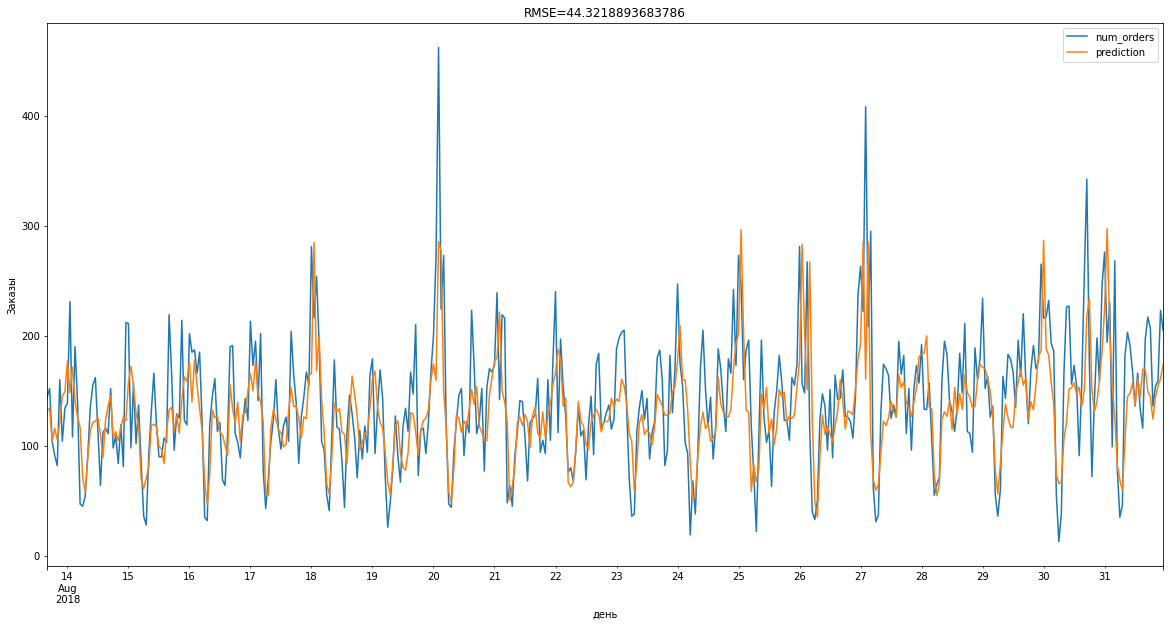

In [61]:
display_result(target_test,rfr.predict(features_test),rfr_rmse)

In [63]:
dmb = DummyRegressor(strategy='mean')
dmb.fit(features_train, target_train)
#dmb_rmse = mean_squared_error(target_test, dmb_prediction, squared=False)
print('Точность наивного прогноза :', mean_squared_error(target_test,dmb.predict(features_test), squared=False))
print('Точность нашего прогноза :',rfr_rmse)

Точность наивного прогноза : 84.68768287118466
Точность нашего прогноза : 44.3218893683786


In [ ]:
display_result(target_test, dmb.predict(features_test),mean_squared_error(target_test, dmb.predict(features_test), squared=False))

провека DummyRegressor показала rmse 84.68 что наша модель предсказвает показала резульатат  44.3218893683786

Нами было проведенно исследование нескольких моделе,подобраны гиперпармаетры.
Самый лучший результат на тренировочной вборке показа RandomForestRegressor RMSE 27.593747335410672
проведя проверку на тестовой выборке она показала RMSE 44.3218893683786. Данныый результат подходит под условеи задча